# CITEMO

## Set working directory

In [1417]:
import warnings
warnings.filterwarnings('ignore')
import os,sys
workdir="./CITEMO/CBMC_figure"
os.chdir(workdir)

## Import dependent packages

In [1051]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from scipy.stats.mstats import gmean
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import umap
from umap import UMAP
import phenograph
import pickle
import umap.plot
from bokeh.plotting import show, save, output_notebook, output_file
output_notebook()
import ray
ray.init(ignore_reinit_error=True)
from sklearn import decomposition
from sklearn.metrics.pairwise import cosine_similarity
rndseed = 100

Loading BokehJS ...

2021-04-05 13:03:43,220	INFO worker.py:666 -- Calling ray.init() again after it has already been called.


## Custom function

### Store and load variables

In [3]:
def saveobj2file(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
    return("save obj to " + filepath)

def loadobj(filepath):
    tempobj = None
    with open(filepath, 'rb') as f:
        tempobj = pickle.load(f)
    
    return tempobj

### Read multi-modal data

In [4]:
def load_umi_matrix(filepath):
    mtx = pd.read_csv(filepath, sep=",", header=0, index_col=0, compression="infer")
    colnames = np.array(mtx.columns.values.tolist())
    rownames = np.array(mtx.index.values.tolist())
    umi = mtx.values
    
    return umi, rownames, colnames

### Preprocessing & Normalization

In [5]:
def get_density(data):
    reusltlist = []
    for gene in data:
        temp = gene!=0
        reusltlist.append(temp.tolist().count(True))
    return np.array(reusltlist)

def preprocess_rnaumidata(data, genenames, expcutoff=3, density=3):
    expcutoff_bool_index = np.sum(data, axis=1)>expcutoff
    density_bool_index = get_density(data)>density
    result_bool_index = expcutoff_bool_index & density_bool_index
    return data[result_bool_index], genenames[result_bool_index]

def non_0_median(data):
    tempdata = data+1
    mindata = np.min(tempdata)
    tempdata = tempdata.astype(float)
    tempdata[tempdata==mindata] = np.nan
    tempdata = np.log2(tempdata.T)/np.log2(np.nanmedian(tempdata,axis=1))
    tempdata = tempdata.T
    tempdata[np.isnan(tempdata)] = mindata
    return tempdata

def clr_normalize(data):
    tempdata = data+1
    result = np.log(tempdata/gmean(tempdata))
    return result

### Other function

In [1901]:
def timecost(start, end):
    print("Starting time："+str(start))
    print("End Time："+str(end))
    cost = (end-start).seconds
    print("Spend time: "+str(cost)+"s")
    return cost

def output_umap(umap_transform, label, filename, figsize=(5, 5), dpi=72, cmap='tab20'):
    plt.figure(figsize=figsize, dpi=dpi)
    plt.axis('off')
    plt.scatter(*umap_transform.T, s=5, c=np.array(label), cmap=cmap, alpha=0.5, marker="o")
    plt.savefig(filename, transparent = True)
    plt.show()
    plt.close()

def adt_dis_sns(adtname, grouplist, y_pred_group, adt_data, title="", grouplist_name=[], loc="upper left", figsize=(5, 5), hist=False, bins=100, xlim=(0,1), ylim=(0,10), filename=""):
    adt_index = np.where(np.array(adtnames_qc)==adtname)[0][0]
    plt.figure(figsize=figsize)
    
    if ""==title:
        plt.title(adtname)
    else:
        plt.title(title)
    
    if(0==len(grouplist_name)):
        for group in grouplist:
            sns.distplot(adt_data[y_pred_group==group][:,adt_index], bins=bins, hist=hist, label=str(group))
    else:
        i = 0
        for group in grouplist:
            sns.distplot(adt_data[y_pred_group==group][:,adt_index], bins=bins, hist=hist, label=grouplist_name[i])
            i += 1
    
    plt.axvline(x=0.5, lw=2, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Expression')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc=loc)
    if filename!="":
        plt.savefig(filename, transparent = True)
    
    plt.show()
    plt.close()
    
def rna_dis(rnaname, grouplist, y_pred_group, rna_umi_matrix, bins=10):
    rna_index = np.where(np.array(genenames)==rnaname)[0][0]
    plt.figure(figsize=(5, 5))
    plt.xlabel('Expression')
    for group in grouplist:
        plt.hist(rna_umi_matrix.T[y_pred_group==group][:,rna_index], bins=bins, alpha=0.5, label=str(group))
    
    plt.legend()
    plt.title(rnaname)
    plt.show()
    plt.close()
    
def cox_quadrant_ratio(adtname1, adtname2, group, y_pred_group, adt_data, x_threshold=0.5,  y_threshold=0.5):
    adt_index1 = np.where(np.array(adtnames_qc)==adtname1)[0][0]
    adt_index2 = np.where(np.array(adtnames_qc)==adtname2)[0][0]

    x = adt_data[y_pred_group==group][:,adt_index1]
    y = adt_data[y_pred_group==group][:,adt_index2]
    
    df = pd.DataFrame({'x':x, 'y':y})
    cellcount = df.shape[0]
    dp = df[(df.x>=x_threshold) & (df.y>=y_threshold)].shape[0]/cellcount
    spx = df[(df.x>x_threshold) & (df.y<y_threshold)].shape[0]/cellcount
    spy = df[(df.x<x_threshold) & (df.y>y_threshold)].shape[0]/cellcount
    dn = df[(df.x<x_threshold) & (df.y<y_threshold)].shape[0]/cellcount
    
    return (dp, spx, spy, dn, cellcount)

def distribution_entropy(dp, spx, spy, dn, cellcount):
    fix_dp = dp
    fix_spx = spx
    fix_spy = spy
    fix_dn = dn
    if 0==fix_dp:
        fix_dp = 1.0/100000
    if 0==fix_spx:
        fix_spx = 1.0/100000
    if 0==fix_spy:
        fix_spy = 1.0/100000
    if 0==fix_dn:
        fix_dn = 1.0/100000
    
    return -1*(fix_dp*math.log(fix_dp, 4) + fix_spx*math.log(fix_spx, 4) + fix_spy*math.log(fix_spy, 4) + fix_dn*math.log(fix_dn, 4))

def cox_adt(adtname1, adtname2, group, y_pred_group, adt_data, setlalel="", color="#d24725", xlim=(0,1), ylim=(0,1), x_threshold=0.5, y_threshold=0.5, filename=""):
    sns.set_style("white")
    adt_index1 = np.where(np.array(adtnames_qc)==adtname1)[0][0]
    adt_index2 = np.where(np.array(adtnames_qc)==adtname2)[0][0]
    plt.figure(figsize=(5, 5))
    #plt.xticks(np.arange(0,1,0.5))
    #plt.yticks(np.arange(0,1,0.5))
    plt.axvline(x=x_threshold, lw=2, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(y=y_threshold, lw=2, color='gray', linestyle='--', alpha=0.5)
    x = adt_data[y_pred_group==group][:,adt_index1]
    y = adt_data[y_pred_group==group][:,adt_index2]

    sns.scatterplot(x=x, y=y, s=50, color=color)
    sns.kdeplot(x=x, y=y, levels=5, color="#c1c1c1", linewidths=1)
        
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(adtname1)
    plt.ylabel(adtname2)
    if ""!=setlalel:
        plt.title("Co-expression of %s and %s\n(%s)" %(adtname1, adtname2, str(setlalel)))
    else:
        plt.title("Co-expression of %s and %s\n(%s)" %(adtname1, adtname2, str(group)))
    
    if filename!="":
        plt.savefig(filename, transparent=True)
    
    plt.show()
    plt.close()
    
    r,p = stats.pearsonr(x, y)
    print('pearsonr r = %6.3f，p_value = %6.3f'%(r,p))
    
    r,p = stats.spearmanr(x, y)
    print('spearmanr r = %6.3f，p_value = %6.3f'%(r,p))
    
    tau, p_value = stats.kendalltau(x, y)
    print('kendalltau r = %6.3f，p_value = %6.3f'%(tau,p_value))
    
    cqr = cox_quadrant_ratio(adtname1, adtname2, group, y_pred_group, adt_data, x_threshold=x_threshold,  y_threshold=y_threshold)
    print("Double positive ratio", cqr[0])
    print(adtname1+" Single positive ratio", cqr[1])
    print(adtname2+" Single positive ratio", cqr[2])
    print("Double negative ratio", cqr[3])
    
    DE = distribution_entropy(cqr[0], cqr[1], cqr[2], cqr[3], cqr[4])
    print("Distribution entropy", DE)

def get_min_max_center(data):
    tempmin = np.min(data)
    tempmax = np.max(data)
    center = (tempmin+tempmax)/2
    return tempmin, tempmax, center

def cox_adt_auto(temp_data, x_name, y_name, labelname, color, group, filename=""):
    temp_min_x, temp_max_x, temp_center_x = get_min_max_center(temp_data[:, adtnames_qc==x_name])
    temp_min_y, temp_max_y, temp_center_y = get_min_max_center(temp_data[:, adtnames_qc==y_name])
    cox_adt(adtname1=x_name, adtname2=y_name, group=group, y_pred_group=y_pred_communities_mo, adt_data=temp_data, setlalel=labelname, color=color, xlim=(temp_min_x, temp_max_x), ylim=(temp_min_y, temp_max_y), x_threshold=temp_center_x, y_threshold=temp_center_y, filename=filename)
    

def draw_swarmplot(data, x, y, setlabelnames=[], title=""):
    ax = sns.swarmplot(x=x, y=y, data=data)
    ax.set_xlabel("")
    setlabelnames_len = len(setlabelnames)
    if setlabelnames_len>0:
        plt.xticks(range(setlabelnames_len), setlabelnames)
    
    plt.title(title)
    plt.show()
    plt.close()

### Set Fontsize

In [1027]:
font = {'family' : 'DejaVu Sans Mono',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
sns.set(font_scale=1.25)
sns.set_style("white")
sns.despine()

<Figure size 432x288 with 0 Axes>

## Load data

In [8]:
import datetime
start = datetime.datetime.now()
filepath = "cbmc.RNA.csv"
rna_umi_matrix, genenames, barcoders  = load_umi_matrix(filepath)
filepath = "cbmc.ADT.csv"
adt_umi_matrix, adtnames, barcoders  = load_umi_matrix(filepath)
end = datetime.datetime.now()
timecost(start, end)

Starting time：2021-03-14 22:27:46.230223
End Time：2021-03-14 22:28:10.381285
Spend time: 24s


24

## Preprocessing

### Gene selection strategy

In [1825]:
expcutoff_value = int(rna_umi_matrix.shape[0]*0.01)
expcutoff_value = 5
density_cutoff_value = int(rna_umi_matrix.shape[0]*0.05)
rna_umi_matrix_qc, featuregenes = preprocess_rnaumidata(rna_umi_matrix, genenames, expcutoff_value, density_cutoff_value)

### Filter low-quality protein

In [10]:
index = np.where((adtnames!="CD10")&(adtnames!="CCR5")&(adtnames!="CCR7"))
adt_umi_matrix_qc = adt_umi_matrix[index]
adtnames_qc = adtnames[index]

## Normalization

In [11]:
rna_data = MinMaxScaler().fit_transform(np.log(1+rna_umi_matrix_qc).T)
adt_data = MinMaxScaler().fit_transform(clr_normalize(adt_umi_matrix_qc).T)

## Single omics dimension reduction

In [12]:
decomposition_pca_rna = decomposition.PCA(n_components=10, random_state=100)
pca_rna = decomposition_pca_rna.fit_transform(rna_data)

decomposition_pca_adt = decomposition.PCA(n_components=10, random_state=100)
pca_adt = decomposition_pca_adt.fit_transform(adt_data)

## Multimodal omics integration

In [13]:
decomposition_pca_mo = decomposition.PCA(n_components=15, random_state=100)
pca_mo = decomposition_pca_mo.fit_transform(np.hstack((MinMaxScaler().fit_transform(pca_rna), MinMaxScaler().fit_transform(pca_adt))))

## Cell clustering

### Single cell transcriptome cell cluster

In [1687]:
communities_rna, graph_rna, Q_rna = phenograph.cluster(pca_rna, k=30, clustering_algo="leiden", resolution_parameter=1, seed=rndseed)
y_pred_communities_rna2 = pd.Categorical(communities_rna)

Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3820044994354248 seconds
Jaccard graph constructed in 5.926817178726196 seconds
Running Leiden optimization
Leiden completed in 0.5304718017578125 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 12.556472301483154 seconds


### ADT cell cluster

In [1916]:
communities_adt, graph_adt, Q_adt = phenograph.cluster(pca_adt, k=30, clustering_algo="leiden", resolution_parameter=1, seed=rndseed)
y_pred_communities_adt = pd.Categorical(communities_adt)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6526198387145996 seconds
Jaccard graph constructed in 9.539319038391113 seconds
Running Leiden optimization
Leiden completed in 0.7741854190826416 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 20.079800367355347 seconds


### Multimodal omics cell cluster

In [220]:
communities_mo, graph_mo, Q_mo = phenograph.cluster(pca_mo, k=10, clustering_algo="leiden", resolution_parameter=1, seed=rndseed)
y_pred_communities_mo = pd.Categorical(communities_mo)

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2994036674499512 seconds
Jaccard graph constructed in 2.9879798889160156 seconds
Running Leiden optimization
Leiden completed in 0.68359375 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.73600697517395 seconds


## Multimodal omics UMAP visualization

In [20]:
model_umap_pred_mo = UMAP(n_neighbors=30, min_dist=0.9, n_components=2, verbose=0)
umap_pred_mo = model_umap_pred_mo.fit(pca_mo)

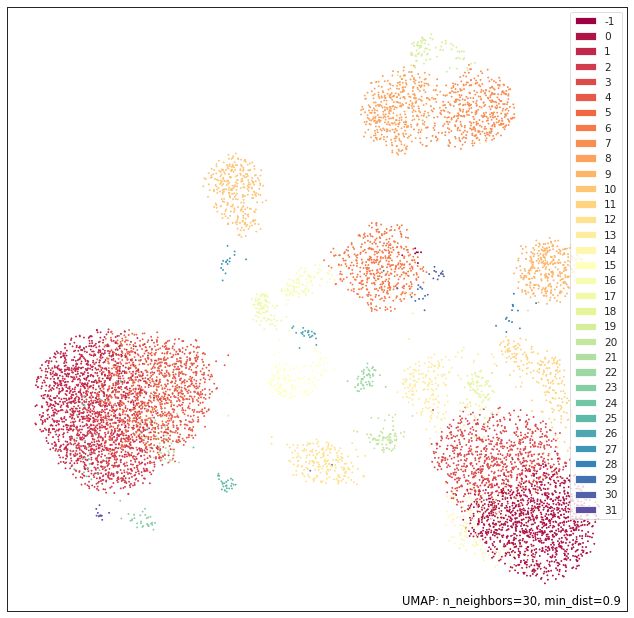

In [1891]:
p_communities_mo = umap.plot.points(umap_pred_mo, labels=np.array(y_pred_communities_mo))

In [1913]:
from bokeh.plotting import show, save, output_notebook, output_file
output_file("CBMC_mo.html")

hover_data_y_pred_communities_mo = pd.DataFrame({'index':barcoders.tolist(),
                           'label':y_pred_communities_mo})
hover_data_y_pred_communities_mo['item'] = hover_data_y_pred_communities_mo.label.map(
    {
        -1:'Mouse'
        0:'CD14+ Monocytes',
        1:'CD4+ Naive T',
        2:'T',
        3:'Monocytes',
        4:'T',
        5:'CD4+ Memory T',
        6:'Mouse 4T1',
        7:'CD8+ NK',
        8:'CD8- NK',
        9:'B',
        10:'CD8+ T',
        11:'CD16+ Monocytes',
        12:'CD4+ T/Mono',
        13:'CD16+ CD45RA+ Monocytes',
        14:'Monocytes',
        15:'CD34+',
        16:'Mouse 3T3',
        17:'Eryth',
        18:'cDC',
        19:'CD56bright NK',
        20:'CD8+ T/Mono',
        21:'T',
        22:'pDC',
        23:'CD4+ CD8dim DP T',
        24:'T',
        25:'T-B conjugates',
        26:'Eryth',
        27:'gdT',
        28:'CD19+ Monocytes',
        31:'CD4+ CD8bright DP T'
    }
)
p_communities_mo = umap.plot.interactive(umap_pred_mo, labels=y_pred_communities_mo, hover_data=hover_data_y_pred_communities_mo, point_size=3)
umap.plot.show(p_communities_mo)

In [ ]:
umap_transform = umap_pred_mo.embedding_

In [1904]:
y_pred_communities_mo_copy = np.array(y_pred_communities_mo.copy())
# Mouse
y_pred_communities_mo_copy[y_pred_communities_mo_copy==-1] = 6
y_pred_communities_mo_copy[y_pred_communities_mo_copy==30] = 6
y_pred_communities_mo_copy[y_pred_communities_mo_copy==29] = 6
# T
y_pred_communities_mo_copy[y_pred_communities_mo_copy==1] = 1
y_pred_communities_mo_copy[y_pred_communities_mo_copy==2] = 1
y_pred_communities_mo_copy[y_pred_communities_mo_copy==24] = 1
y_pred_communities_mo_copy[y_pred_communities_mo_copy==4] = 5
y_pred_communities_mo_copy[y_pred_communities_mo_copy==5] = 5
y_pred_communities_mo_copy[y_pred_communities_mo_copy==21] = 5
# Monocytes
y_pred_communities_mo_copy[y_pred_communities_mo_copy==14] = 0
y_pred_communities_mo_copy[y_pred_communities_mo_copy==3] = 0
# Eryth
y_pred_communities_mo_copy[y_pred_communities_mo_copy==17] = 26

In [1905]:
from bokeh.plotting import show, save, output_notebook, output_file
output_file("CBMC_mo_withlabel.html")

hover_data_y_pred_communities_mo_copy = pd.DataFrame({'index':barcoders.tolist(),
                           'label':y_pred_communities_mo_copy})
hover_data_y_pred_communities_mo_copy_map_dict = {
        0:'CD14+ Monocytes',
        1:'CD4+ Naive T',
        5:'CD4+ Memory T',
        6:'Mouse 4T1',
        7:'CD8+ NK',
        8:'CD8- NK',
        9:'B',
        10:'CD8+ T',
        11:'CD16+ Monocytes',
        12:'CD4+ T/Mono',
        13:'CD16+ CD45RA+ Monocytes',
        15:'CD34+',
        16:'Mouse 3T3',
        18:'cDC',
        19:'CD56bright NK',
        20:'CD8+ T/Mono',
        22:'pDC',
        23:'CD4+ CD8dim DP T',
        25:'T-B conjugates',
        26:'Eryth',
        27:'gdT',
        28:'CD19+ Monocytes',
        31:'CD4+ CD8bright DP T'
    }
hover_data_y_pred_communities_mo_copy['item'] = hover_data_y_pred_communities_mo_copy.label.map(hover_data_y_pred_communities_mo_copy_map_dict)
p_communities_mo_copy = umap.plot.interactive(umap_pred_mo, labels=y_pred_communities_mo_copy, hover_data=hover_data_y_pred_communities_mo_copy, point_size=3)
umap.plot.show(p_communities_mo_copy)

## Co-expression rate and distribution entropy

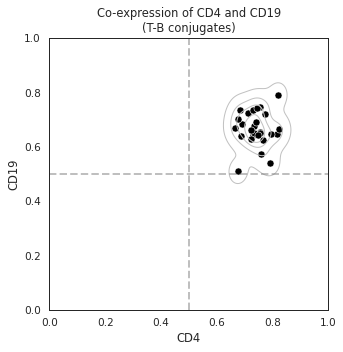

pearsonr r =  0.046，p_value =  0.818
spearmanr r = -0.051，p_value =  0.802
kendalltau r = -0.020，p_value =  0.901
Double positive ratio 1.0
CD4 Single positive ratio 0.0
CD19 Single positive ratio 0.0
Double negative ratio 0.0
Distribution entropy 0.0002491446071165522


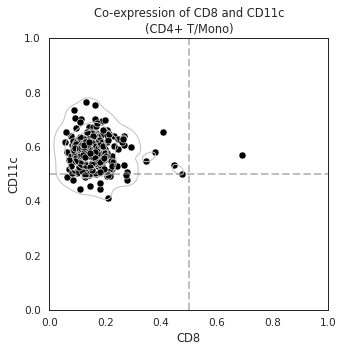

pearsonr r = -0.081，p_value =  0.245
spearmanr r = -0.039，p_value =  0.576
kendalltau r = -0.025，p_value =  0.591
Double positive ratio 0.0048543689320388345
CD8 Single positive ratio 0.0
CD11c Single positive ratio 0.912621359223301
Double negative ratio 0.0825242718446602
Distribution entropy 0.22743629136521537


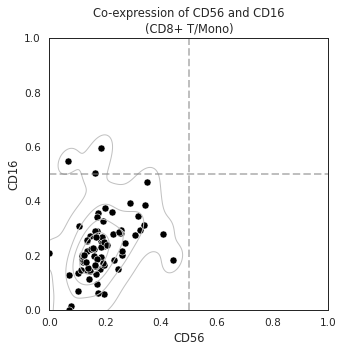

pearsonr r =  0.335，p_value =  0.003
spearmanr r =  0.452，p_value =  0.000
kendalltau r =  0.323，p_value =  0.000
Double positive ratio 0.0
CD56 Single positive ratio 0.0
CD16 Single positive ratio 0.04
Double negative ratio 0.96
Distribution entropy 0.12131219094595178


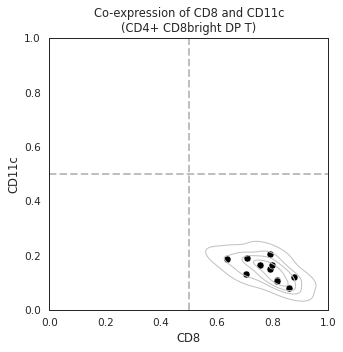

pearsonr r = -0.606，p_value =  0.048
spearmanr r = -0.691，p_value =  0.019
kendalltau r = -0.491，p_value =  0.041
Double positive ratio 0.0
CD8 Single positive ratio 1.0
CD11c Single positive ratio 0.0
Double negative ratio 0.0
Distribution entropy 0.0002491446071165522


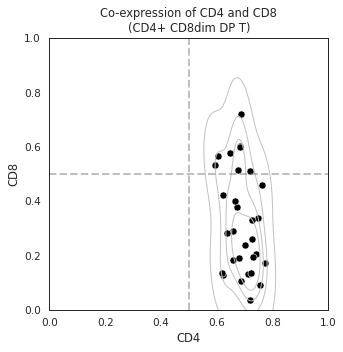

pearsonr r = -0.289，p_value =  0.121
spearmanr r = -0.283，p_value =  0.130
kendalltau r = -0.168，p_value =  0.201
Double positive ratio 0.26666666666666666
CD4 Single positive ratio 0.7333333333333333
CD8 Single positive ratio 0.0
Double negative ratio 0.0
Distribution entropy 0.4184864673753281


In [1902]:
cox_adt(adtname1="CD4", adtname2="CD19", group=25, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="T-B conjugates", color="black")
cox_adt(adtname1="CD8", adtname2="CD11c", group=12, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD4+ T/Mono", color="black")
cox_adt(adtname1="CD56", adtname2="CD16", group=20, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD8+ T/Mono", color="black")
cox_adt(adtname1="CD8", adtname2="CD11c", group=31, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD4+ CD8bright DP T", color="black")
cox_adt(adtname1="CD4", adtname2="CD8", group=23, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD4+ CD8dim DP T", color="black")

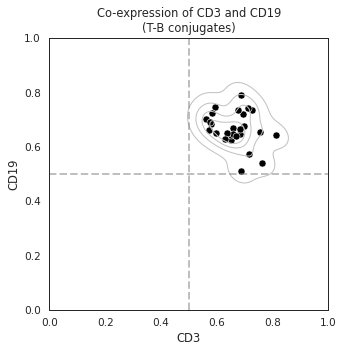

pearsonr r = -0.249，p_value =  0.211
spearmanr r = -0.164，p_value =  0.413
kendalltau r = -0.117，p_value =  0.408
Double positive ratio 1.0
CD3 Single positive ratio 0.0
CD19 Single positive ratio 0.0
Double negative ratio 0.0
Distribution entropy 0.0002491446071165522


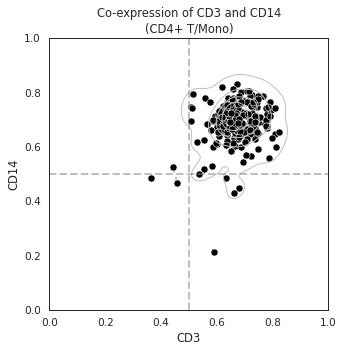

pearsonr r =  0.240，p_value =  0.001
spearmanr r =  0.130，p_value =  0.062
kendalltau r =  0.091，p_value =  0.053
Double positive ratio 0.9660194174757282
CD3 Single positive ratio 0.019417475728155338
CD14 Single positive ratio 0.0048543689320388345
Double negative ratio 0.009708737864077669
Distribution entropy 0.1304145852222254


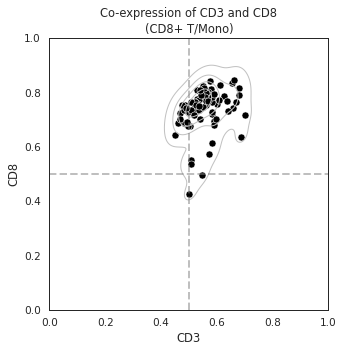

pearsonr r =  0.289，p_value =  0.012
spearmanr r =  0.386，p_value =  0.001
kendalltau r =  0.276，p_value =  0.000
Double positive ratio 0.7866666666666666
CD3 Single positive ratio 0.02666666666666667
CD8 Single positive ratio 0.18666666666666668
Double negative ratio 0.0
Distribution entropy 0.4319663346426121


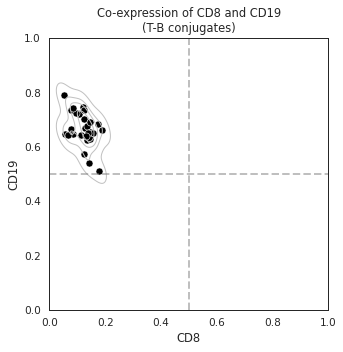

pearsonr r = -0.453，p_value =  0.018
spearmanr r = -0.373，p_value =  0.055
kendalltau r = -0.282，p_value =  0.040
Double positive ratio 0.0
CD8 Single positive ratio 0.0
CD19 Single positive ratio 1.0
Double negative ratio 0.0
Distribution entropy 0.0002491446071165522


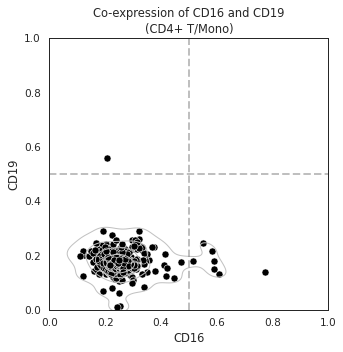

pearsonr r = -0.070，p_value =  0.318
spearmanr r = -0.064，p_value =  0.359
kendalltau r = -0.045，p_value =  0.333
Double positive ratio 0.0
CD16 Single positive ratio 0.03398058252427184
CD19 Single positive ratio 0.0048543689320388345
Double negative ratio 0.9611650485436893
Distribution entropy 0.12910007094406406


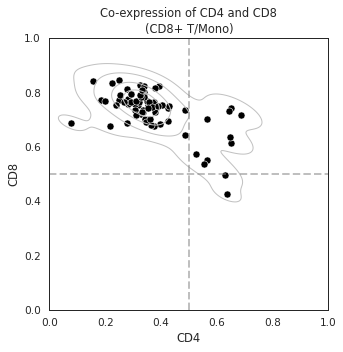

pearsonr r = -0.609，p_value =  0.000
spearmanr r = -0.517，p_value =  0.000
kendalltau r = -0.364，p_value =  0.000
Double positive ratio 0.12
CD4 Single positive ratio 0.02666666666666667
CD8 Single positive ratio 0.8533333333333334
Double negative ratio 0.0
Distribution entropy 0.35096356003044055


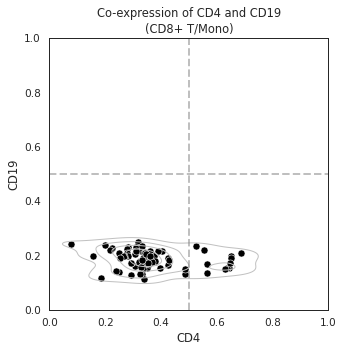

pearsonr r = -0.184，p_value =  0.113
spearmanr r = -0.205，p_value =  0.077
kendalltau r = -0.131，p_value =  0.097
Double positive ratio 0.0
CD4 Single positive ratio 0.14666666666666667
CD19 Single positive ratio 0.0
Double negative ratio 0.8533333333333334
Distribution entropy 0.30088378961928297


In [1925]:
cox_adt(adtname1="CD3", adtname2="CD19", group=25, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="T-B conjugates", color="black")
cox_adt(adtname1="CD3", adtname2="CD14", group=12, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD4+ T/Mono", color="black")
cox_adt(adtname1="CD3", adtname2="CD8", group=20, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD8+ T/Mono", color="black")

cox_adt(adtname1="CD8", adtname2="CD19", group=25, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="T-B conjugates", color="black")
cox_adt(adtname1="CD16", adtname2="CD19", group=12, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD4+ T/Mono", color="black")
cox_adt(adtname1="CD4", adtname2="CD8", group=20, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD8+ T/Mono", color="black")
cox_adt(adtname1="CD4", adtname2="CD19", group=20, y_pred_group=y_pred_communities_mo, adt_data=adt_data, setlalel="CD8+ T/Mono", color="black")


## Seurat v3 with Multimodal omics UMAP visualization

In [1895]:
seurat_label_filepath = "/home/hh/bigdata/hh/SVAE/CBMC/seurat_lables.csv"

seurat_label = pd.read_csv(seurat_label_filepath, sep=',', header=None)
seuratlabellist = np.squeeze(seurat_label.values[1:,1:seurat_label.shape[1]].astype(np.str)).tolist()
uniquelist = np.unique(seuratlabellist).tolist()
index = 0
indexlist = []
for unique in uniquelist:
    index = uniquelist.index(unique)
    seuratlabellist = [index if x == unique else x for x in seuratlabellist]

seuratlabellist = np.array(seuratlabellist)

hover_data_seurat = pd.DataFrame({'index':barcoders.tolist(),
                           'label':seuratlabellist.tolist()})
hover_data_seurat['item'] = hover_data_seurat.label.map(
    {
        0:'B',
        1:'CD14+ Mono',
        2:'CD14+ Mono',
        3:'CD16+ Mono',
        4:'CD34+',
        5:'CD8 T',
        6:'DC',
        7:'Eryth',
        8:'Memory CD4 T',
        9:'Mk',
        10:'Mouse',
        11:'Multiplets',
        12:'NK',
        13:'NK',
        14:'Naive CD4 T',
        15:'T/Mono doublets',
        16:'pDCs'
    }
)

p = umap.plot.interactive(umap_pred_mo, labels=seuratlabellist, hover_data=hover_data_seurat, point_size=3)
umap.plot.show(p)

## Single cell transcriptome with Multimodal omics UMAP visualization

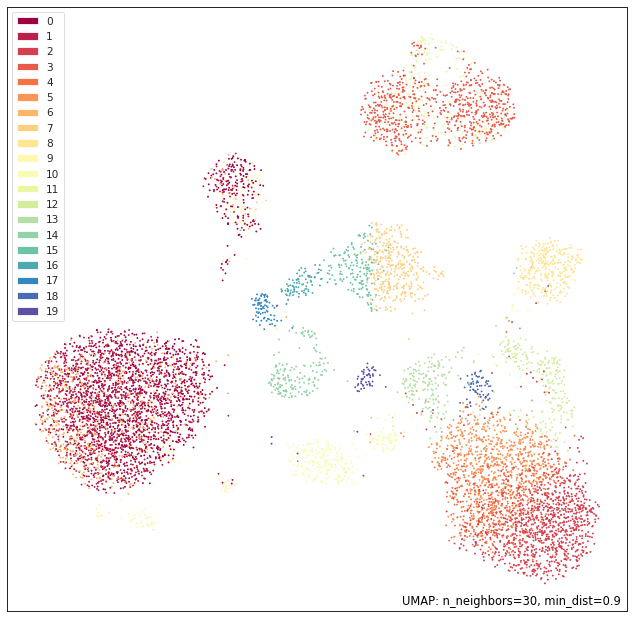

In [1897]:
p_communities_rna_by_moumap = umap.plot.points(umap_pred_mo, labels=np.array(y_pred_communities_rna))

## ADT visualization through multimodal omics UMAP

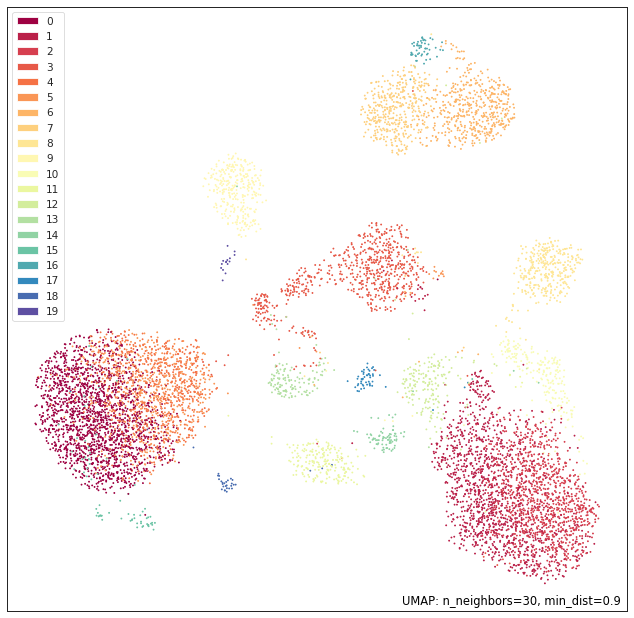

In [1898]:
p_communities_adt_by_moumap = umap.plot.points(umap_pred_mo, labels=np.array(y_pred_communities_adt))

## Visualization of markers

### Visualization of ADT level markers

In [1907]:
def draw_marker_output(pobj, type, value, title, width=5, height=5, dpi=72, point_size=10, label_colors=cm.get_cmap('YlOrRd')):
    plt.figure(figsize=(width, height), dpi=dpi)
    sc = plt.scatter(pobj[:, 0], pobj[:, 1], c=value, cmap=label_colors, s=point_size, marker="o",alpha=1)
    #plt.colorbar(sc)
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.xlabel(type+"_1")
    plt.ylabel(type+"_2")

def cutoff(data):
    tempdata = np.array(data.tolist())#一个技巧 否则会变成在修改引用
    nonzero_index = np.nonzero(tempdata)
    zeroindex = np.where(0==tempdata)
    c95 = np.percentile(tempdata[nonzero_index], 75)
    c05 = np.percentile(tempdata[nonzero_index], 15)
    #tempdata[tempdata>c95] = c95
    tempdata[tempdata<c05] = 0
    tempdata[zeroindex] = 0
    return tempdata    

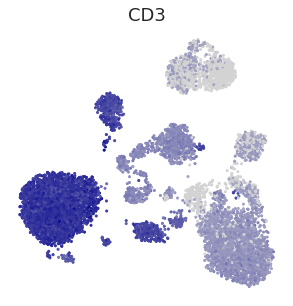

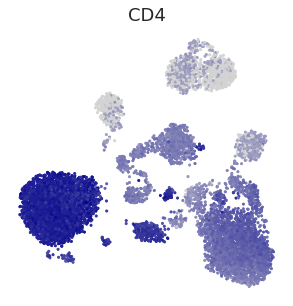

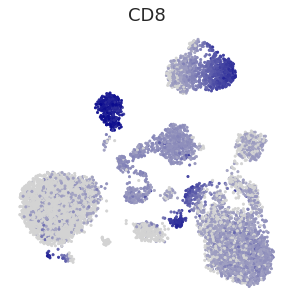

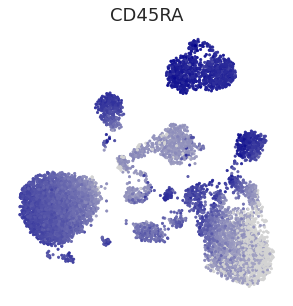

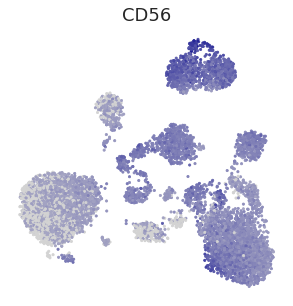

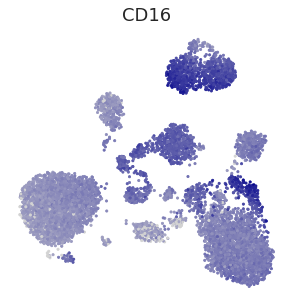

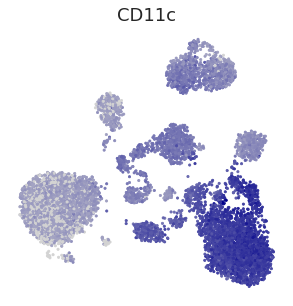

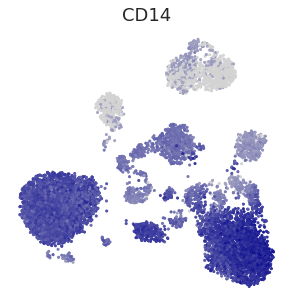

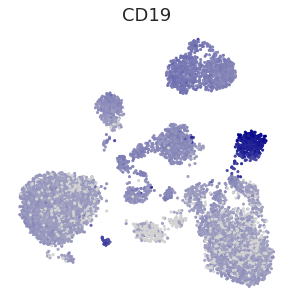

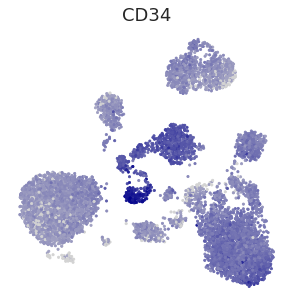

In [1908]:
cdict = ['lightgrey', "darkblue"]
cmap_pro = colors.LinearSegmentedColormap.from_list('pro_color', cdict)
cm.register_cmap(cmap=cmap_pro)
cutoff_adt_data = cutoff(adt_data)
for pn in adtnames_qc:
    Marker_index = np.where(np.array(adtnames_qc)==pn)
    Marker_pro_data = MaxAbsScaler().fit_transform(cutoff_adt_data[:,Marker_index[0][0]].reshape(adt_data.shape[0],1))
    draw_marker_output(umap_transform, type="umap_", value=Marker_pro_data, title=pn, point_size=5, width=5, height=5, dpi=72, label_colors=cm.get_cmap('pro_color'))
    plt.show()
    plt.close()

### Visualization of genes

In [1909]:
def cutoff(data):
    tempdata = np.array(data.tolist())
    nonzero_index = np.nonzero(tempdata)
    zeroindex = np.where(0==tempdata)
    c95 = np.percentile(tempdata[nonzero_index], 75)
    c05 = np.percentile(tempdata[nonzero_index], 25)
    #tempdata[tempdata>c95] = c95
    tempdata[tempdata<c05] = c05
    tempdata[zeroindex] = 0
    return tempdata 

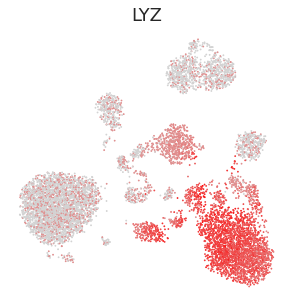

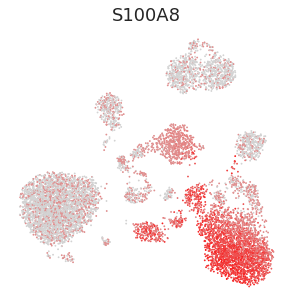

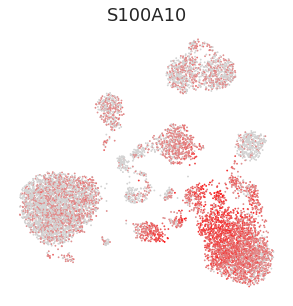

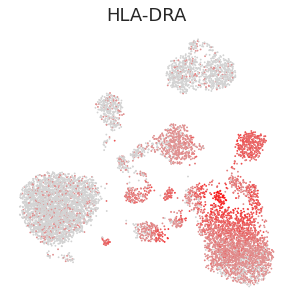

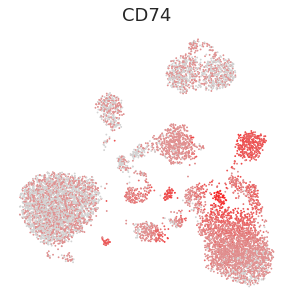

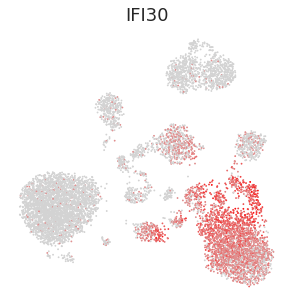

In [1912]:
cdict = ['lightgrey', 'red']
cmap_rna = colors.LinearSegmentedColormap.from_list('rna_color', cdict)
cm.register_cmap(cmap=cmap_rna)
temp_rna_data = MinMaxScaler().fit_transform(np.log(1+rna_umi_matrix).T)
rna_markers = ["LYZ", "S100A8", "S100A10", "HLA-DRA", "CD74", "IFI30"]
cutoff_rna_data = cutoff(temp_rna_data)
for rn in rna_markers:
    Marker_index = np.where(np.array(genenames)==rn)
    Marker_rna_data = MaxAbsScaler().fit_transform(cutoff_rna_data[:,Marker_index[0][0]].reshape(temp_rna_data.shape[0],1))
    draw_marker_output(umap_transform, type="umap_", value=Marker_rna_data, title=rn, point_size=1, width=5, height=5, dpi=72, label_colors=cm.get_cmap('rna_color'))
    plt.show()
    plt.close()
